# CSI Data Exploration

This notebook provides comprehensive exploration of the CSI episode transcription data to understand:
- Character distributions and speaking patterns
- Episode structure and timing
- Gold label (killer) statistics
- Basic linguistic patterns

This analysis is performed on the raw data before any neural network training.

In [1]:
# Setup and imports
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path('.').absolute().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Project root: {project_root}")
print(f"Python path includes: {sys.path[:3]}")

Project root: /Users/eholgate/research/csi-diss-25
Python path includes: ['/Users/eholgate/research/csi-diss-25/src', '/Users/eholgate/research/csi-diss-25', '/Library/Frameworks/Python.framework/Versions/3.13/lib/python313.zip']


In [2]:
# Import our data processing modules
from data.preprocessing import load_csi_data_complete, normalize_character_name
from data.models import Episode, Character, Sentence

# Load the complete dataset
data_dir = project_root / 'data' / 'original'
print(f"Loading data from: {data_dir}")

# Load in episode-isolated mode for initial analysis
csi_data = load_csi_data_complete(data_dir, character_mode='episode-isolated')

episodes = csi_data['episodes']
summary_stats = csi_data['summary_stats']

print("\n=== Dataset Summary ===")
for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value}")

Loading data from: /Users/eholgate/research/csi-diss-25/data/original

=== Dataset Summary ===
character_mode: episode-isolated
total_episodes: 39
total_sentences: 26188
total_characters_instances: 1102
unique_characters: 1102
avg_sentences_per_episode: 671.49
avg_characters_per_episode: 28.26


## 1. Episode-Level Statistics

Episode Statistics Summary:
       num_sentences  num_characters  total_words
count      39.000000       39.000000    39.000000
mean      671.487179       28.256410  4414.666667
std        62.069516        4.794284   445.564180
min       496.000000       16.000000  3257.000000
25%       632.500000       25.500000  4183.000000
50%       671.000000       29.000000  4354.000000
75%       714.500000       31.500000  4736.500000
max       813.000000       40.000000  5263.000000


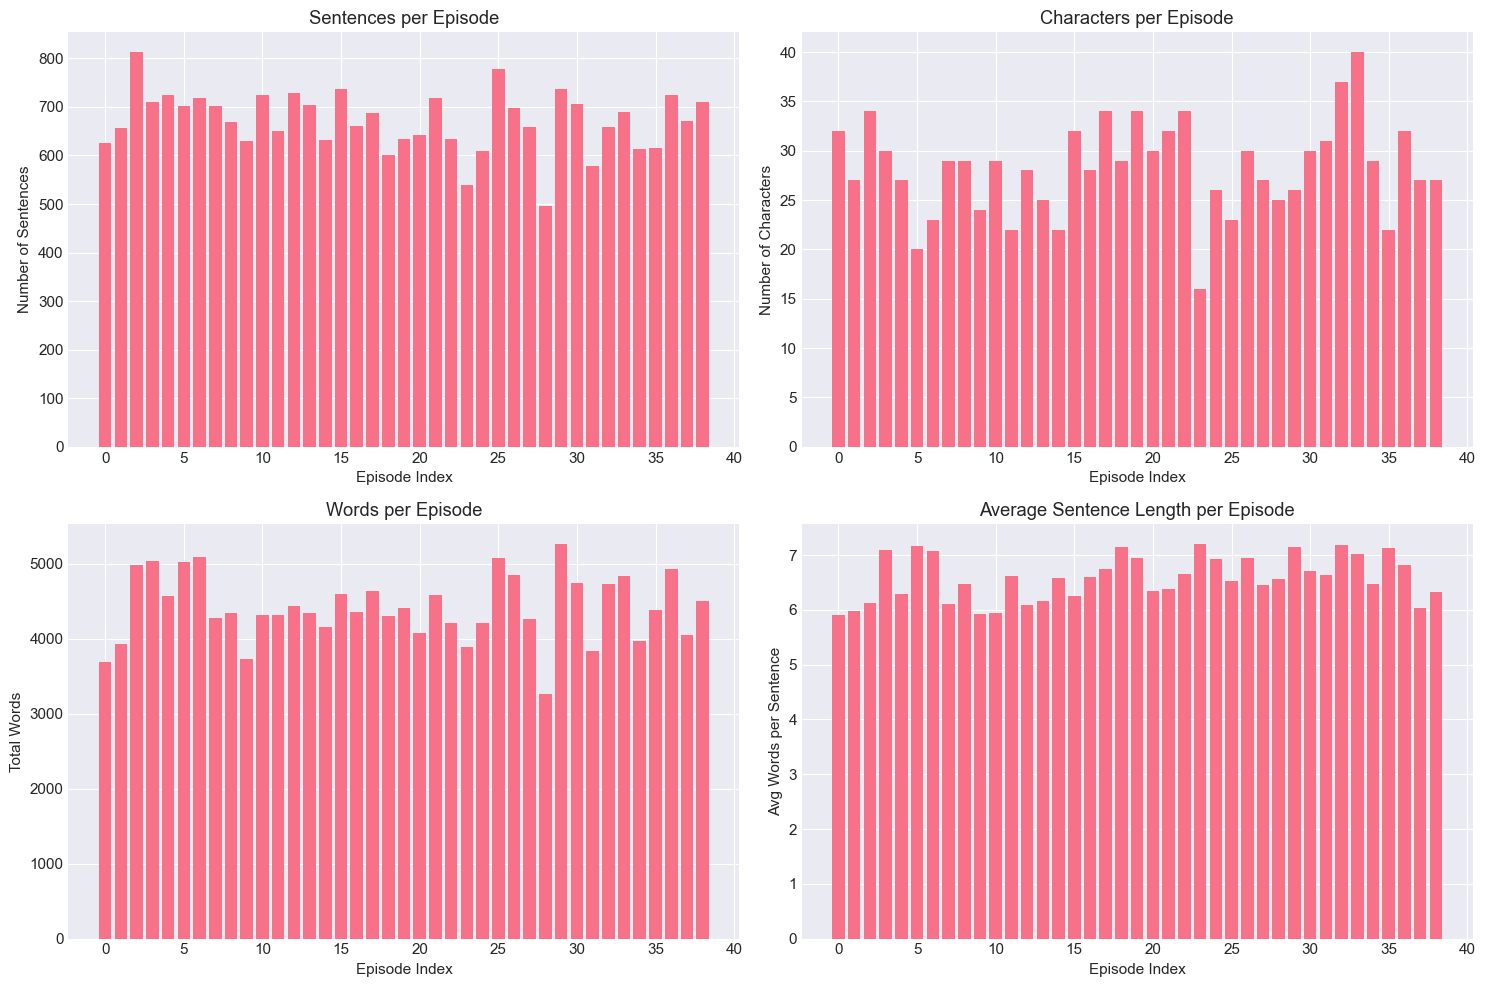


Average Statistics by Season:
        num_sentences  num_characters  total_words
season                                            
1               705.3            28.3       4538.3
2               682.5            26.0       4343.0
3               678.4            28.3       4402.6
4               640.9            27.7       4282.0
5               670.3            30.1       4524.6


In [3]:
# Analyze episode-level statistics
episode_stats = []

for episode in episodes:
    # Count unique speakers
    unique_speakers = set()
    total_words = 0
    
    for sentence in episode.sentences:
        if sentence.speaker:
            unique_speakers.add(sentence.speaker.normalized_name)
        total_words += len(sentence.text.split())
    
    episode_stats.append({
        'episode_id': episode.episode_id,
        'season': int(episode.episode_id[1:3]),
        'episode_num': int(episode.episode_id[4:]),
        'num_sentences': len(episode.sentences),
        'num_characters': len(episode.characters),
        'num_unique_speakers': len(unique_speakers),
        'total_words': total_words,
        'avg_words_per_sentence': total_words / len(episode.sentences) if episode.sentences else 0
    })

episode_df = pd.DataFrame(episode_stats)
episode_df = episode_df.sort_values(['season', 'episode_num'])

print("Episode Statistics Summary:")
print(episode_df[['episode_id', 'num_sentences', 'num_characters', 'total_words']].describe())

# Plot episode statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sentences per episode
axes[0, 0].bar(range(len(episode_df)), episode_df['num_sentences'])
axes[0, 0].set_xlabel('Episode Index')
axes[0, 0].set_ylabel('Number of Sentences')
axes[0, 0].set_title('Sentences per Episode')

# Characters per episode
axes[0, 1].bar(range(len(episode_df)), episode_df['num_characters'])
axes[0, 1].set_xlabel('Episode Index')
axes[0, 1].set_ylabel('Number of Characters')
axes[0, 1].set_title('Characters per Episode')

# Words per episode
axes[1, 0].bar(range(len(episode_df)), episode_df['total_words'])
axes[1, 0].set_xlabel('Episode Index')
axes[1, 0].set_ylabel('Total Words')
axes[1, 0].set_title('Words per Episode')

# Average words per sentence
axes[1, 1].bar(range(len(episode_df)), episode_df['avg_words_per_sentence'])
axes[1, 1].set_xlabel('Episode Index')
axes[1, 1].set_ylabel('Avg Words per Sentence')
axes[1, 1].set_title('Average Sentence Length per Episode')

plt.tight_layout()
plt.show()

# Season progression
season_stats = episode_df.groupby('season').agg({
    'num_sentences': 'mean',
    'num_characters': 'mean',
    'total_words': 'mean'
}).round(1)

print("\nAverage Statistics by Season:")
print(season_stats)

## 2. Character Frequency Analysis

Top 20 Most Talkative Characters:
               character  sentences_spoken  words_spoken  num_episodes
1                grissom              3903         26479            38
11             catherine              3046         20515            37
17                 brass              2038         14360            39
4                   sara              2021         12952            37
10               warrick              1979         13452            38
12                  nick              1866         11918            36
120              robbins               688          4798            33
124                 greg               580          3860            32
16         davidphillips               161           996            23
488         miadickerson               146          1020             7
49       dominickretzker               135           821             1
361           alanbrooks               133           860             1
268          davidhodges               129 

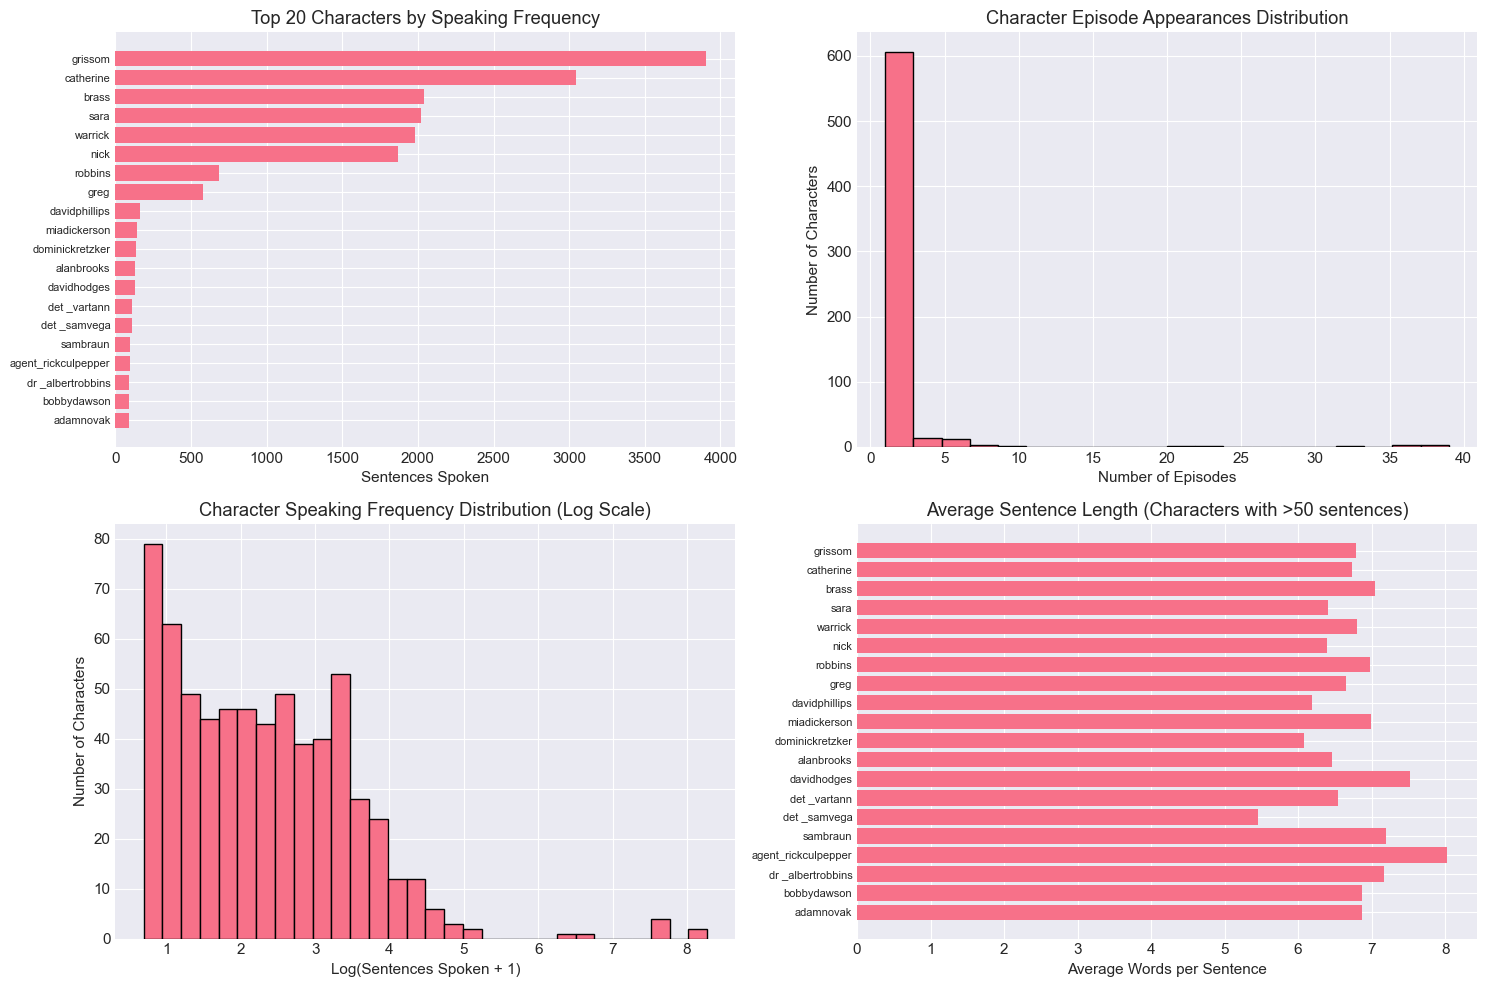


Main Characters (appearing in 10+ episodes): 11
         character  num_episodes  sentences_spoken
17           brass            39              2038
1          grissom            38              3903
10         warrick            38              1979
11       catherine            37              3046
4             sara            37              2021
12            nick            36              1866
120        robbins            33               688
124           greg            32               580
16   davidphillips            23               161
13         officer            21                55


In [4]:
# Analyze character appearances and speaking frequency
character_stats = defaultdict(lambda: {
    'appearances': 0,
    'sentences_spoken': 0,
    'words_spoken': 0,
    'episodes': set()
})

for episode in episodes:
    episode_characters = set()
    
    for sentence in episode.sentences:
        if sentence.speaker:
            char_name = sentence.speaker.normalized_name.lower()
            character_stats[char_name]['sentences_spoken'] += 1
            character_stats[char_name]['words_spoken'] += len(sentence.text.split())
            character_stats[char_name]['episodes'].add(episode.episode_id)
            episode_characters.add(char_name)
    
    # Count appearances (characters in episode)
    for char_name in episode_characters:
        character_stats[char_name]['appearances'] += 1

# Convert to DataFrame
char_data = []
for char_name, stats in character_stats.items():
    char_data.append({
        'character': char_name,
        'appearances': stats['appearances'],
        'sentences_spoken': stats['sentences_spoken'],
        'words_spoken': stats['words_spoken'],
        'num_episodes': len(stats['episodes']),
        'avg_words_per_sentence': stats['words_spoken'] / stats['sentences_spoken'] if stats['sentences_spoken'] > 0 else 0
    })

char_df = pd.DataFrame(char_data)
char_df = char_df.sort_values('sentences_spoken', ascending=False)

print("Top 20 Most Talkative Characters:")
print(char_df.head(20)[['character', 'sentences_spoken', 'words_spoken', 'num_episodes']])

# Visualize character distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Top 20 characters by sentences spoken
top_20 = char_df.head(20)
axes[0, 0].barh(range(len(top_20)), top_20['sentences_spoken'])
axes[0, 0].set_yticks(range(len(top_20)))
axes[0, 0].set_yticklabels(top_20['character'], fontsize=8)
axes[0, 0].set_xlabel('Sentences Spoken')
axes[0, 0].set_title('Top 20 Characters by Speaking Frequency')
axes[0, 0].invert_yaxis()

# Distribution of character appearances
axes[0, 1].hist(char_df['num_episodes'], bins=20, edgecolor='black')
axes[0, 1].set_xlabel('Number of Episodes')
axes[0, 1].set_ylabel('Number of Characters')
axes[0, 1].set_title('Character Episode Appearances Distribution')

# Speaking frequency distribution (log scale)
axes[1, 0].hist(np.log1p(char_df['sentences_spoken']), bins=30, edgecolor='black')
axes[1, 0].set_xlabel('Log(Sentences Spoken + 1)')
axes[1, 0].set_ylabel('Number of Characters')
axes[1, 0].set_title('Character Speaking Frequency Distribution (Log Scale)')

# Average words per sentence by character
top_speakers = char_df[char_df['sentences_spoken'] > 50].head(20)
axes[1, 1].barh(range(len(top_speakers)), top_speakers['avg_words_per_sentence'])
axes[1, 1].set_yticks(range(len(top_speakers)))
axes[1, 1].set_yticklabels(top_speakers['character'], fontsize=8)
axes[1, 1].set_xlabel('Average Words per Sentence')
axes[1, 1].set_title('Average Sentence Length (Characters with >50 sentences)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Identify main characters (appear in many episodes)
main_characters = char_df[char_df['num_episodes'] >= 10].sort_values('num_episodes', ascending=False)
print(f"\nMain Characters (appearing in 10+ episodes): {len(main_characters)}")
print(main_characters[['character', 'num_episodes', 'sentences_spoken']].head(10))

## 3. Gold Label (Killer) Analysis

Killer Statistics Summary:
Episodes with killers identified: 39 / 39
Average killers per episode: 8.74
Average suspects per episode: 9.46

Killer sentence statistics:
Average killer sentences per episode: 33.3
Average suspect sentences per episode: 40.0


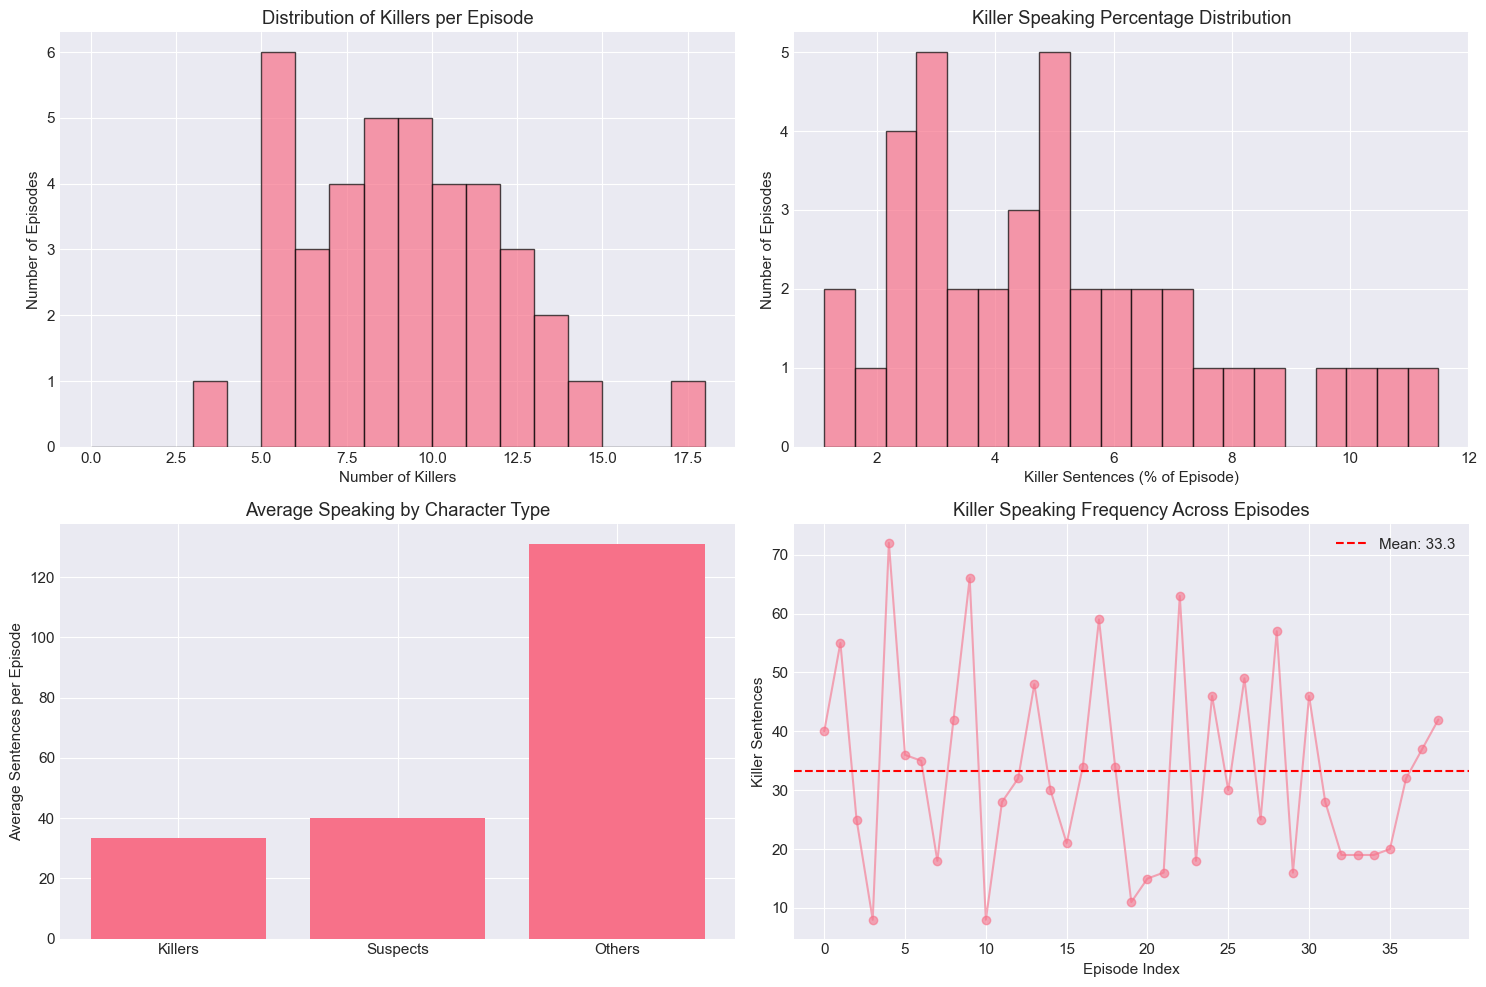


Episodes without identified killers: 0


In [5]:
# Analyze killer gold labels
killer_stats = []

for episode in episodes:
    killers = set()
    suspects = set()
    others = set()
    
    killer_sentences = 0
    suspect_sentences = 0
    other_sentences = 0
    
    for sentence in episode.sentences:
        if sentence.speaker and sentence.gold_labels:
            char_name = sentence.speaker.normalized_name.lower()
            
            if sentence.gold_labels.get('killer_gold') == 'Y':
                killers.add(char_name)
                killer_sentences += 1
            
            if sentence.gold_labels.get('suspect_gold') == 'Y':
                suspects.add(char_name)
                suspect_sentences += 1
            
            if sentence.gold_labels.get('other_gold') == 'Y':
                others.add(char_name)
                other_sentences += 1
    
    killer_stats.append({
        'episode_id': episode.episode_id,
        'num_killers': len(killers),
        'num_suspects': len(suspects),
        'num_others': len(others),
        'killer_sentences': killer_sentences,
        'suspect_sentences': suspect_sentences,
        'other_sentences': other_sentences,
        'killers': list(killers),
        'total_sentences': len(episode.sentences)
    })

killer_df = pd.DataFrame(killer_stats)

print("Killer Statistics Summary:")
print(f"Episodes with killers identified: {(killer_df['num_killers'] > 0).sum()} / {len(killer_df)}")
print(f"Average killers per episode: {killer_df['num_killers'].mean():.2f}")
print(f"Average suspects per episode: {killer_df['num_suspects'].mean():.2f}")
print(f"\nKiller sentence statistics:")
print(f"Average killer sentences per episode: {killer_df['killer_sentences'].mean():.1f}")
print(f"Average suspect sentences per episode: {killer_df['suspect_sentences'].mean():.1f}")

# Visualize killer statistics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Killers per episode distribution
axes[0, 0].hist(killer_df['num_killers'], bins=range(0, killer_df['num_killers'].max()+2), 
                edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Killers')
axes[0, 0].set_ylabel('Number of Episodes')
axes[0, 0].set_title('Distribution of Killers per Episode')

# Killer sentences as percentage of episode
killer_df['killer_sentence_pct'] = killer_df['killer_sentences'] / killer_df['total_sentences'] * 100
axes[0, 1].hist(killer_df['killer_sentence_pct'], bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Killer Sentences (% of Episode)')
axes[0, 1].set_ylabel('Number of Episodes')
axes[0, 1].set_title('Killer Speaking Percentage Distribution')

# Comparison of character types
char_type_means = [
    killer_df['killer_sentences'].mean(),
    killer_df['suspect_sentences'].mean(),
    killer_df['other_sentences'].mean()
]
axes[1, 0].bar(['Killers', 'Suspects', 'Others'], char_type_means)
axes[1, 0].set_ylabel('Average Sentences per Episode')
axes[1, 0].set_title('Average Speaking by Character Type')

# Killer presence over episodes
axes[1, 1].plot(killer_df['killer_sentences'], marker='o', linestyle='-', alpha=0.6)
axes[1, 1].set_xlabel('Episode Index')
axes[1, 1].set_ylabel('Killer Sentences')
axes[1, 1].set_title('Killer Speaking Frequency Across Episodes')
axes[1, 1].axhline(y=killer_df['killer_sentences'].mean(), color='r', 
                   linestyle='--', label=f'Mean: {killer_df["killer_sentences"].mean():.1f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Episodes without killers
no_killer_episodes = killer_df[killer_df['num_killers'] == 0]
print(f"\nEpisodes without identified killers: {len(no_killer_episodes)}")
if len(no_killer_episodes) > 0:
    print("Episodes:", no_killer_episodes['episode_id'].tolist())

## 4. Killer Speaking Patterns Analysis

Speaking Pattern Comparison:

Killer sentences: 15165
Non-killer sentences: 11023

Average sentence length:
  Killers: 6.59 words
  Non-killers: 6.55 words

Question usage:
  Killers: 0.0% of sentences
  Non-killers: 0.0% of sentences

Exclamation usage:
  Killers: 0.0% of sentences
  Non-killers: 0.0% of sentences


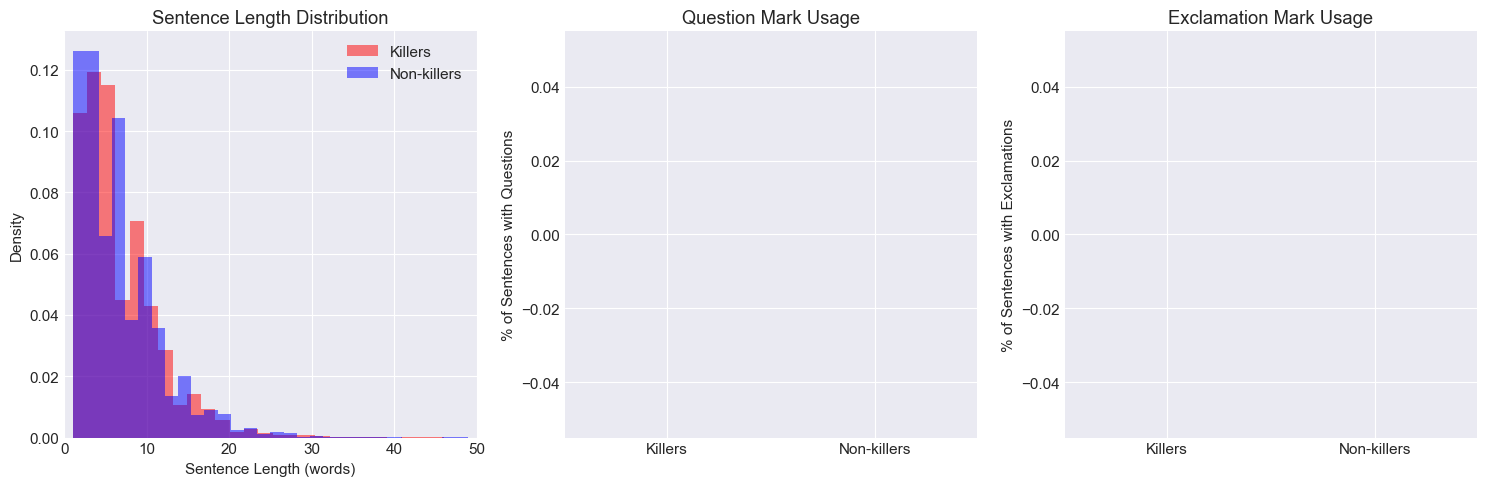

In [6]:
# Analyze speaking patterns of killers vs non-killers
killer_speaking_patterns = []
non_killer_speaking_patterns = []

for episode in episodes:
    # Identify killers in this episode
    episode_killers = set()
    
    for sentence in episode.sentences:
        if sentence.speaker and sentence.gold_labels:
            if sentence.gold_labels.get('killer_gold') == 'Y':
                episode_killers.add(sentence.speaker.normalized_name.lower())
    
    # Analyze speaking patterns
    for sentence in episode.sentences:
        if sentence.speaker:
            char_name = sentence.speaker.normalized_name.lower()
            sentence_length = len(sentence.text.split())
            
            pattern_data = {
                'sentence_length': sentence_length,
                'has_question': '?' in sentence.text,
                'has_exclamation': '!' in sentence.text,
                'episode': episode.episode_id
            }
            
            if char_name in episode_killers:
                killer_speaking_patterns.append(pattern_data)
            else:
                non_killer_speaking_patterns.append(pattern_data)

# Convert to DataFrames
killer_patterns_df = pd.DataFrame(killer_speaking_patterns)
non_killer_patterns_df = pd.DataFrame(non_killer_speaking_patterns)

print("Speaking Pattern Comparison:")
print(f"\nKiller sentences: {len(killer_patterns_df)}")
print(f"Non-killer sentences: {len(non_killer_patterns_df)}")

if len(killer_patterns_df) > 0:
    print(f"\nAverage sentence length:")
    print(f"  Killers: {killer_patterns_df['sentence_length'].mean():.2f} words")
    print(f"  Non-killers: {non_killer_patterns_df['sentence_length'].mean():.2f} words")
    
    print(f"\nQuestion usage:")
    print(f"  Killers: {killer_patterns_df['has_question'].mean()*100:.1f}% of sentences")
    print(f"  Non-killers: {non_killer_patterns_df['has_question'].mean()*100:.1f}% of sentences")
    
    print(f"\nExclamation usage:")
    print(f"  Killers: {killer_patterns_df['has_exclamation'].mean()*100:.1f}% of sentences")
    print(f"  Non-killers: {non_killer_patterns_df['has_exclamation'].mean()*100:.1f}% of sentences")
    
    # Statistical comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Sentence length distribution
    axes[0].hist(killer_patterns_df['sentence_length'], bins=30, alpha=0.5, 
                 label='Killers', density=True, color='red')
    axes[0].hist(non_killer_patterns_df['sentence_length'], bins=30, alpha=0.5, 
                 label='Non-killers', density=True, color='blue')
    axes[0].set_xlabel('Sentence Length (words)')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Sentence Length Distribution')
    axes[0].legend()
    axes[0].set_xlim(0, 50)
    
    # Question usage comparison
    question_data = [
        killer_patterns_df['has_question'].mean() * 100,
        non_killer_patterns_df['has_question'].mean() * 100
    ]
    axes[1].bar(['Killers', 'Non-killers'], question_data, color=['red', 'blue'], alpha=0.7)
    axes[1].set_ylabel('% of Sentences with Questions')
    axes[1].set_title('Question Mark Usage')
    
    # Exclamation usage comparison
    exclamation_data = [
        killer_patterns_df['has_exclamation'].mean() * 100,
        non_killer_patterns_df['has_exclamation'].mean() * 100
    ]
    axes[2].bar(['Killers', 'Non-killers'], exclamation_data, color=['red', 'blue'], alpha=0.7)
    axes[2].set_ylabel('% of Sentences with Exclamations')
    axes[2].set_title('Exclamation Mark Usage')
    
    plt.tight_layout()
    plt.show()
else:
    print("No killer data available for pattern analysis")

## 5. Temporal Analysis - When Do Killers Speak?

Temporal Analysis of Killer Speaking:

Killer sentences by episode quartile:
  Q1 (0-25%): 3403 sentences (22.4%)
  Q2 (25-50%): 3556 sentences (23.4%)
  Q3 (50-75%): 3737 sentences (24.6%)
  Q4 (75-100%): 4469 sentences (29.5%)


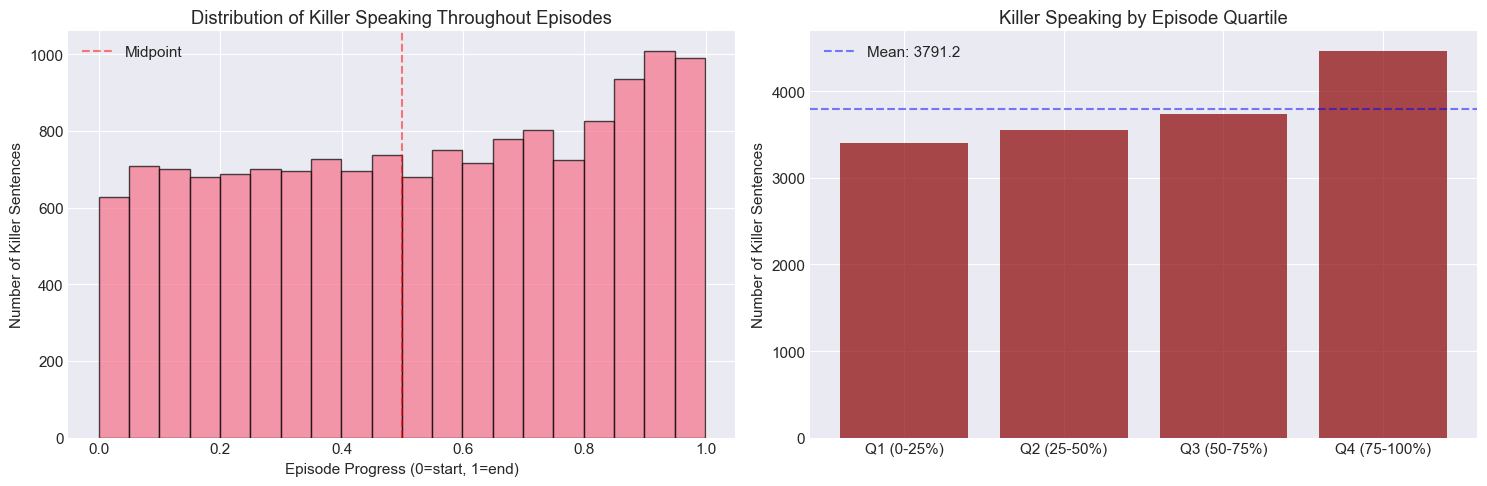


Killer first appearance statistics:
  Average first appearance: 1.5% through episode
  Earliest appearance: 0.0% through episode
  Latest appearance: 9.4% through episode


In [7]:
# Analyze when killers speak during episodes
temporal_analysis = []

for episode in episodes:
    # Identify killers
    episode_killers = set()
    for sentence in episode.sentences:
        if sentence.speaker and sentence.gold_labels:
            if sentence.gold_labels.get('killer_gold') == 'Y':
                episode_killers.add(sentence.speaker.normalized_name.lower())
    
    if not episode_killers or len(episode.sentences) == 0:
        continue
    
    # Track killer speaking over episode progress
    total_sentences = len(episode.sentences)
    for i, sentence in enumerate(episode.sentences):
        if sentence.speaker:
            char_name = sentence.speaker.normalized_name.lower()
            if char_name in episode_killers:
                temporal_analysis.append({
                    'episode': episode.episode_id,
                    'position': i,
                    'relative_position': i / total_sentences,
                    'quartile': min(3, int(4 * i / total_sentences)),
                    'is_killer': True
                })

temporal_df = pd.DataFrame(temporal_analysis)

if len(temporal_df) > 0:
    print("Temporal Analysis of Killer Speaking:")
    
    # Quartile analysis
    quartile_counts = temporal_df['quartile'].value_counts().sort_index()
    quartile_labels = ['Q1 (0-25%)', 'Q2 (25-50%)', 'Q3 (50-75%)', 'Q4 (75-100%)']
    
    print("\nKiller sentences by episode quartile:")
    for q in range(4):
        count = quartile_counts.get(q, 0)
        pct = count / len(temporal_df) * 100
        print(f"  {quartile_labels[q]}: {count} sentences ({pct:.1f}%)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Distribution over episode progress
    axes[0].hist(temporal_df['relative_position'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Episode Progress (0=start, 1=end)')
    axes[0].set_ylabel('Number of Killer Sentences')
    axes[0].set_title('Distribution of Killer Speaking Throughout Episodes')
    axes[0].axvline(x=0.5, color='r', linestyle='--', alpha=0.5, label='Midpoint')
    axes[0].legend()
    
    # Quartile distribution
    quartile_data = [quartile_counts.get(q, 0) for q in range(4)]
    axes[1].bar(quartile_labels, quartile_data, color='darkred', alpha=0.7)
    axes[1].set_ylabel('Number of Killer Sentences')
    axes[1].set_title('Killer Speaking by Episode Quartile')
    axes[1].axhline(y=np.mean(quartile_data), color='blue', linestyle='--', 
                    alpha=0.5, label=f'Mean: {np.mean(quartile_data):.1f}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # First appearance analysis
    first_appearances = temporal_df.groupby('episode')['relative_position'].min()
    print(f"\nKiller first appearance statistics:")
    print(f"  Average first appearance: {first_appearances.mean()*100:.1f}% through episode")
    print(f"  Earliest appearance: {first_appearances.min()*100:.1f}% through episode")
    print(f"  Latest appearance: {first_appearances.max()*100:.1f}% through episode")
else:
    print("No temporal data available for killers")

## 6. Character Co-occurrence Analysis

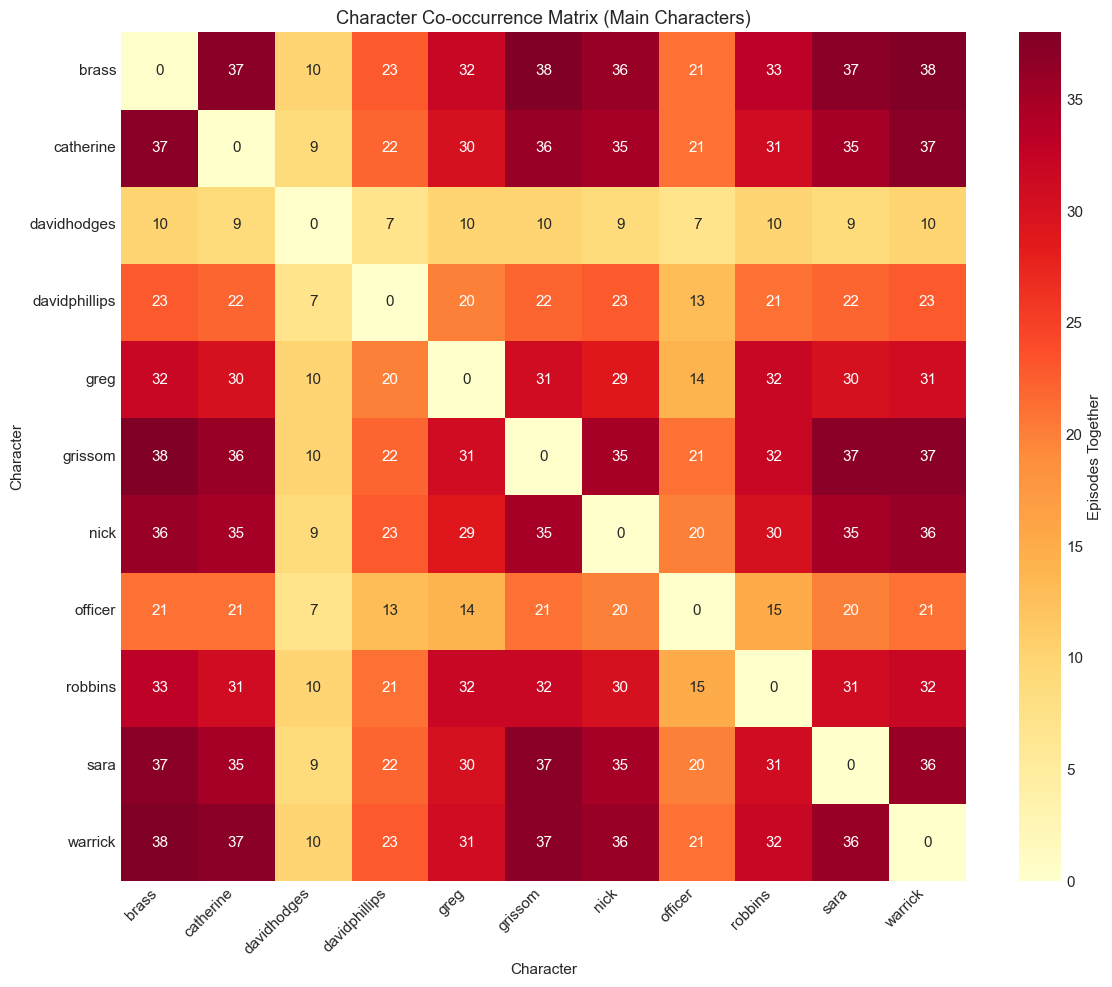


Strongest Character Relationships (5+ episodes together):
  brass & grissom: 38 episodes
  brass & warrick: 38 episodes
  brass & catherine: 37 episodes
  brass & sara: 37 episodes
  catherine & warrick: 37 episodes
  grissom & sara: 37 episodes
  grissom & warrick: 37 episodes
  brass & nick: 36 episodes
  catherine & grissom: 36 episodes
  nick & warrick: 36 episodes
  sara & warrick: 36 episodes
  catherine & nick: 35 episodes
  catherine & sara: 35 episodes
  grissom & nick: 35 episodes
  nick & sara: 35 episodes


In [8]:
# Analyze which characters appear together
from itertools import combinations

co_occurrence = defaultdict(int)
character_episodes = defaultdict(set)

for episode in episodes:
    episode_chars = set()
    for char in episode.characters:
        char_name = char.normalized_name.lower()
        episode_chars.add(char_name)
        character_episodes[char_name].add(episode.episode_id)
    
    # Count co-occurrences
    for char1, char2 in combinations(sorted(episode_chars), 2):
        co_occurrence[(char1, char2)] += 1

# Find main characters (appear in many episodes)
main_chars = [char for char, eps in character_episodes.items() if len(eps) >= 10]
main_chars = sorted(main_chars)[:15]  # Top 15 main characters

if len(main_chars) > 0:
    # Create co-occurrence matrix for main characters
    co_matrix = np.zeros((len(main_chars), len(main_chars)))
    
    for i, char1 in enumerate(main_chars):
        for j, char2 in enumerate(main_chars):
            if i < j:
                key = (char1, char2) if char1 < char2 else (char2, char1)
                co_matrix[i, j] = co_occurrence.get(key, 0)
                co_matrix[j, i] = co_matrix[i, j]
    
    # Visualize co-occurrence matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(co_matrix, annot=True, fmt='.0f', cmap='YlOrRd',
                xticklabels=main_chars, yticklabels=main_chars,
                cbar_kws={'label': 'Episodes Together'})
    plt.title('Character Co-occurrence Matrix (Main Characters)')
    plt.xlabel('Character')
    plt.ylabel('Character')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Find strongest character relationships
    strong_pairs = []
    for (char1, char2), count in co_occurrence.items():
        if char1 in main_chars and char2 in main_chars and count >= 5:
            strong_pairs.append((char1, char2, count))
    
    strong_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("\nStrongest Character Relationships (5+ episodes together):")
    for char1, char2, count in strong_pairs[:15]:
        print(f"  {char1} & {char2}: {count} episodes")
else:
    print("Not enough main characters for co-occurrence analysis")

## 7. Data Quality Assessment

Data Quality Assessment:

Sentence Statistics:
  Total sentences: 26188
  With speakers: 26188 (100.0%)
  Without speakers: 0 (0.0%)
  Empty sentences: 0

Annotation Coverage:
  Sentences with gold labels: 26188 (100.0%)
  Sentences with timing data: 26188 (100.0%)

Character Name Normalization:
  Unique raw names: 646
  Unique normalized names: 646
  Reduction ratio: 0.0%


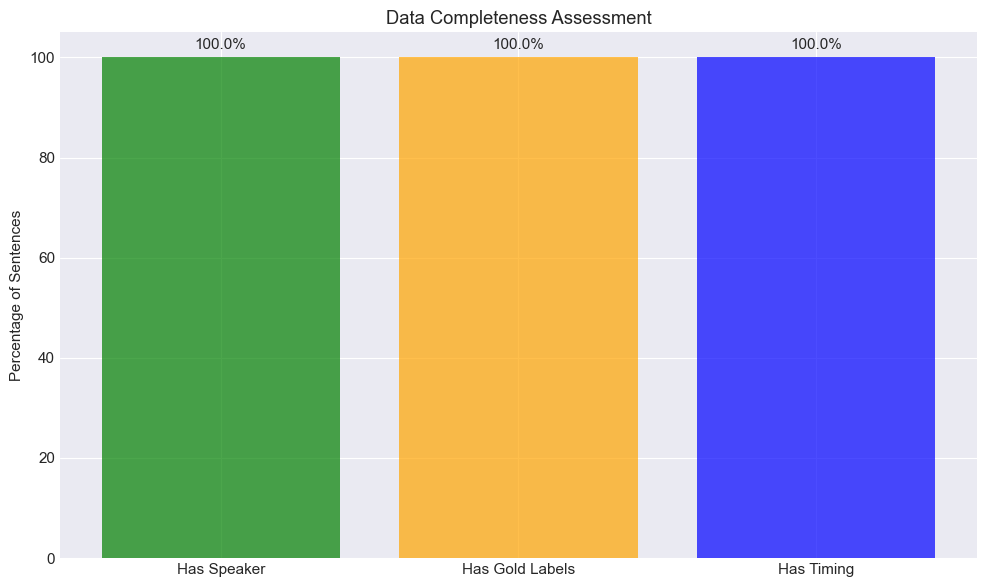

In [9]:
# Assess data quality and completeness
quality_stats = {
    'total_episodes': len(episodes),
    'total_sentences': sum(len(ep.sentences) for ep in episodes),
    'sentences_with_speakers': 0,
    'sentences_without_speakers': 0,
    'sentences_with_gold_labels': 0,
    'sentences_with_timing': 0,
    'unique_raw_names': set(),
    'unique_normalized_names': set(),
    'empty_sentences': 0
}

for episode in episodes:
    for sentence in episode.sentences:
        # Check speaker
        if sentence.speaker:
            quality_stats['sentences_with_speakers'] += 1
            quality_stats['unique_raw_names'].add(sentence.speaker.raw_name)
            quality_stats['unique_normalized_names'].add(sentence.speaker.normalized_name)
        else:
            quality_stats['sentences_without_speakers'] += 1
        
        # Check gold labels
        if sentence.gold_labels and any(sentence.gold_labels.values()):
            quality_stats['sentences_with_gold_labels'] += 1
        
        # Check timing data
        if sentence.timing_data and sentence.timing_data.get('start_time'):
            quality_stats['sentences_with_timing'] += 1
        
        # Check for empty sentences
        if not sentence.text or len(sentence.text.strip()) == 0:
            quality_stats['empty_sentences'] += 1

print("Data Quality Assessment:")
print(f"\nSentence Statistics:")
print(f"  Total sentences: {quality_stats['total_sentences']}")
print(f"  With speakers: {quality_stats['sentences_with_speakers']} ({quality_stats['sentences_with_speakers']/quality_stats['total_sentences']*100:.1f}%)")
print(f"  Without speakers: {quality_stats['sentences_without_speakers']} ({quality_stats['sentences_without_speakers']/quality_stats['total_sentences']*100:.1f}%)")
print(f"  Empty sentences: {quality_stats['empty_sentences']}")

print(f"\nAnnotation Coverage:")
print(f"  Sentences with gold labels: {quality_stats['sentences_with_gold_labels']} ({quality_stats['sentences_with_gold_labels']/quality_stats['total_sentences']*100:.1f}%)")
print(f"  Sentences with timing data: {quality_stats['sentences_with_timing']} ({quality_stats['sentences_with_timing']/quality_stats['total_sentences']*100:.1f}%)")

print(f"\nCharacter Name Normalization:")
print(f"  Unique raw names: {len(quality_stats['unique_raw_names'])}")
print(f"  Unique normalized names: {len(quality_stats['unique_normalized_names'])}")
print(f"  Reduction ratio: {(1 - len(quality_stats['unique_normalized_names'])/len(quality_stats['unique_raw_names']))*100:.1f}%")

# Visualize data completeness
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Has Speaker', 'Has Gold Labels', 'Has Timing']
percentages = [
    quality_stats['sentences_with_speakers'] / quality_stats['total_sentences'] * 100,
    quality_stats['sentences_with_gold_labels'] / quality_stats['total_sentences'] * 100,
    quality_stats['sentences_with_timing'] / quality_stats['total_sentences'] * 100
]

bars = ax.bar(categories, percentages, color=['green', 'orange', 'blue'], alpha=0.7)
ax.set_ylabel('Percentage of Sentences')
ax.set_title('Data Completeness Assessment')
ax.set_ylim(0, 105)

# Add percentage labels on bars
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Summary and Key Findings

This notebook provides comprehensive exploration of the CSI dataset. Key findings will be summarized here after running all analyses.

In [10]:
# Generate summary report
print("=" * 60)
print("CSI DATASET EXPLORATION SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Scale:")
print(f"  • {len(episodes)} episodes analyzed")
print(f"  • {sum(len(ep.sentences) for ep in episodes):,} total sentences")
print(f"  • {len(quality_stats['unique_normalized_names']):,} unique characters")

print(f"\n👥 Character Insights:")
if len(main_characters) > 0:
    print(f"  • {len(main_characters)} main characters (10+ episode appearances)")
    print(f"  • Top speaker: {char_df.iloc[0]['character']} ({char_df.iloc[0]['sentences_spoken']} sentences)")

print(f"\n🔍 Killer Analysis:")
print(f"  • Episodes with killers: {(killer_df['num_killers'] > 0).sum()}/{len(killer_df)}")
print(f"  • Average killer sentences per episode: {killer_df['killer_sentences'].mean():.1f}")
if len(temporal_df) > 0:
    print(f"  • Killers typically first appear {first_appearances.mean()*100:.1f}% through episode")

print(f"\n✅ Data Quality:")
print(f"  • {quality_stats['sentences_with_speakers']/quality_stats['total_sentences']*100:.1f}% sentences have speakers")
print(f"  • {quality_stats['sentences_with_gold_labels']/quality_stats['total_sentences']*100:.1f}% have gold labels")
print(f"  • Character name normalization reduced unique names by {(1 - len(quality_stats['unique_normalized_names'])/len(quality_stats['unique_raw_names']))*100:.1f}%")

print("\n" + "=" * 60)

CSI DATASET EXPLORATION SUMMARY

📊 Dataset Scale:
  • 39 episodes analyzed
  • 26,188 total sentences
  • 646 unique characters

👥 Character Insights:
  • 11 main characters (10+ episode appearances)
  • Top speaker: grissom (3903 sentences)

🔍 Killer Analysis:
  • Episodes with killers: 39/39
  • Average killer sentences per episode: 33.3
  • Killers typically first appear 1.5% through episode

✅ Data Quality:
  • 100.0% sentences have speakers
  • 100.0% have gold labels
  • Character name normalization reduced unique names by 0.0%

